In [105]:
import os, torch, torch.nn as nn, torchvision, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import PIL.Image as Image
import re
import numpy as np
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torchvision.models import resnet50

img_folder = '/Users/liam/Documents/Python/working/flower_images/'

In [106]:
# obtain the list of images from the folder and its subfolders
img_list = []
for path, subdirs, files in os.walk(img_folder):
    for name in files:
        img_list.append(os.path.join(path, name))

In [107]:
for img in img_list:
    if not img.endswith('.jpg'):
        img_list.remove(img)

In [108]:
labels = []
for img in img_list:
    label = re.findall(r'flower_images\/(.*)\/', img)[0]
    labels.append(label)

# print unique labels
print(set(labels))

# count classes in labels
from collections import Counter
Counter(labels)

{'Tulip', 'Orchid', 'Sunflower', 'Lotus', 'Lilly'}


Counter({'Lotus': 1000,
         'Tulip': 1000,
         'Orchid': 1000,
         'Lilly': 999,
         'Sunflower': 1000})

In [109]:
classes = list(set(labels))
classes_idx = {classes[i]: i for i in range(len(classes))}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


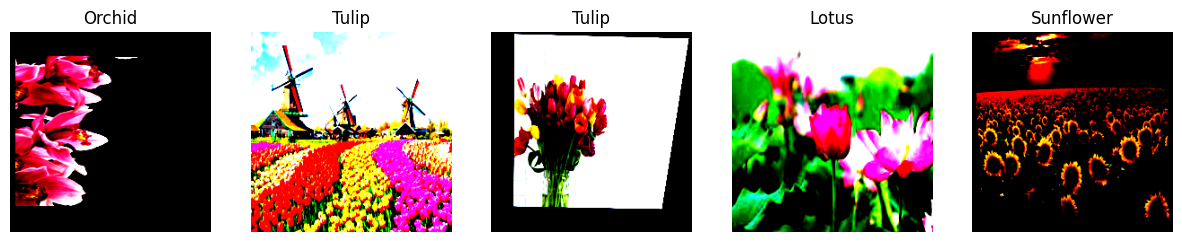

In [110]:
class FlowerDataset(Dataset):
    def __init__(self, img_list, labels, classes_idx, transform=None):
        self.img_list = img_list
        self.labels = labels
        self.classes_idx = classes_idx
        self.transform = transform

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_list[idx])
        img = img.convert('RGB')
        label = self.labels[idx]
        label = self.classes_idx[label]
        if self.transform:
            img = self.transform(img)
        return img, label
    
transform=torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300), antialias=True),
    # horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),
    # jitter brightness, contrast and saturation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # randomly crop image
    transforms.RandomCrop(224, pad_if_needed=True, padding_mode='reflect'),
    # warp
    transforms.RandomPerspective(distortion_scale=0.3, p=0.6),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

sample_dataset = FlowerDataset(img_list, labels, classes_idx, transform=transform)
sample_loader = DataLoader(sample_dataset, batch_size=10, shuffle=True)

# visualize a batch of images using the dataloader
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(figsize=(15, 10), ncols=5)
    for i in range(5):
        axes[i].imshow(images[i].permute(1, 2, 0))
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

show_batch_images(sample_loader)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(img_list, labels, test_size=0.2, random_state=42)

In [112]:
# use a pretrained resnet50 model
class MyResNet(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.resnet50=resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet50.fc=nn.Sequential(
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 5)
        )
        for param in self.resnet50.parameters():
            param.requires_grad = False

        for param in self.resnet50.fc.parameters():
            param.requires_grad = True

    def forward(self, xb):
        return self.resnet50(xb)

In [113]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [114]:
def get_accuracy(model, data_loader):
    correct_pred = 0
    n = 0
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)
            _, y_prob = model(X).max(1)
            n += y_true.size(0)
            correct_pred += (y_prob == y_true).sum()
    return correct_pred.float() / n

In [115]:
batch_size = 32

train_dataset = FlowerDataset(X_train, y_train, classes_idx, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = FlowerDataset(X_test, y_test, classes_idx, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [116]:
lr = 0.001
loss_fn = nn.CrossEntropyLoss()

def train_batch(model, optimizer, xb, yb):
    xb = xb.to(device)
    yb = yb.to(device)
    y_hat = model(xb)
    loss = loss_fn(y_hat, yb)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    preds=torch.argmax(y_hat, dim=1)
    return loss.item(), (preds==yb).sum().item()/len(preds)

def train_epoch(model, optimizer, x, y):
    losses = []
    accuracies = []
    for xb, yb in tqdm(train_loader):
        loss, accuracy = train_batch(model, optimizer, xb, yb)
        losses.append(loss)
        accuracies.append(accuracy)
    return losses, np.mean(accuracies), get_accuracy(model, test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

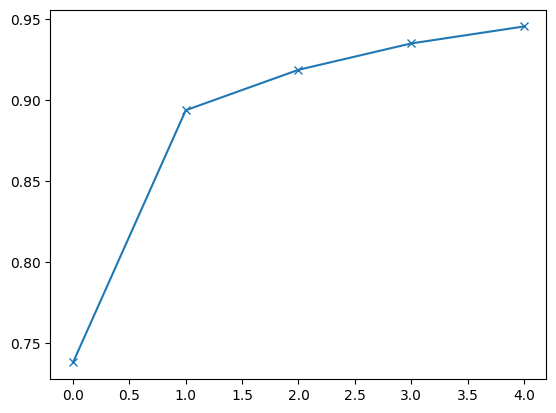

In [117]:
model = MyResNet()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model = model.to(device)

EPOCHS = 5
train_accs=[]
test_accs=[]

bar = tqdm(range(EPOCHS))
for epoch in bar:
    losses, train_acc, test_acc = train_epoch(model, optimizer, X_train, y_train)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    bar.set_description(f'Epoch: {epoch+1}, Train Acc: {train_acc:.5f}, Test Acc: {test_acc:.5f}')

# plot the training and test accuracies
plt.plot(train_accs, '-x', label='Training')
plt.plot(test_accs, '-o', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()